# The representation of concept hierarchies across languages in LLMs

**Abstract:** This paper investigates how large language models (LLMs) represent semantic hierarchies across languages, examining whether the degree of cross-lingual similarity varies based on concept generality. Analyzing activations from Gemma 2 2B across seven languages, we extract representations of hierarchically related concepts and apply linear discriminant analysis to eliminate distractor directions. We find that more specific concepts exhibit higher cross-lingual similarity than general ones, with statistically significant differences between the most general and specific concepts. This pattern suggests that concrete, specific concepts may have more stable cross-lingual representations in LLMs than abstract, general ones, potentially due to their more consistent usage across languages. Our exploratory study outlines methodological considerations for probing multilingual concept representations and proposes directions for investigating the geometric structure of semantic hierarchies in the activation space of language models.

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
from rich import print as rprint

In [3]:
import pickle
from pathlib import Path


def fload(path: str | Path):
  """Load a pickled object from a file."""
  with open(path, "rb") as f:
    return pickle.load(f)


def fdump(path: str | Path, obj):
  """Dump a pickled object to a file."""
  with open(path, "wb") as f:
    pickle.dump(obj, f)

In [4]:
PLOTS_DIR = Path("plots")
TABLES_DIR = Path("tables")
CACHED_DATA_DIR = Path("cached_data")  # Large files not committed to repo

In [5]:
import torch

device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
rprint(f"Using device: [b]{device}[/b]")

Using device: mps

In [6]:
MODEL_ID = "gemma-2-2b"

In [7]:
from transformer_lens import HookedTransformer

model = HookedTransformer.from_pretrained(
  model_name=MODEL_ID,
  center_unembed=False,
  center_writing_weights=False,
  device=device,
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


In [8]:
MODEL_HOOK_IDS = ["blocks.1.hook_resid_post", "blocks.4.hook_resid_post", "blocks.8.hook_resid_post", "blocks.12.hook_resid_post"]
assert all(hook_id in model.hook_dict for hook_id in MODEL_HOOK_IDS), "Invalid hooks"

In [9]:
# Focusing on the final layer
MODEL_HOOK_ID = MODEL_HOOK_IDS[3]
MODEL_HOOK_ID

'blocks.12.hook_resid_post'

## Dataset


In [10]:
%aimport dataset
from dataset import CONCEPTS

In [11]:
# Print model vocabulary
vocab = model.tokenizer.get_vocab()
vocab = sorted(vocab.keys(), key=lambda x: vocab[x])
# vocab

In [12]:
# Tokenize all concepts
from collections import defaultdict

concept_tokenizations = defaultdict(dict)
for lang in CONCEPTS:
  for concept in CONCEPTS[lang]:
    concept_tokens = model.to_tokens(concept, prepend_bos=False).squeeze(0)
    concept_str_tokens = model.to_str_tokens(concept_tokens, prepend_bos=False)
    concept_tokenizations[lang][concept] = concept_str_tokens

In [13]:
from rich.table import Table

table = Table(title="Multi-token words in the model's vocabulary", highlight=True)
table.add_column("Language")
table.add_column("Multi-token words")
table.add_column("Percentage")
for lang in concept_tokenizations:
  n_multi_token_words = sum((len(tokenization) > 1) for tokenization in concept_tokenizations[lang].values())
  table.add_row(
    lang,
    f"[b red]{n_multi_token_words}[/]",
    f"{n_multi_token_words / len(concept_tokenizations[lang]):.1%}",
  )

table

 Multi-token words in the model's vocabulary 
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Language ┃ Multi-token words ┃ Percentage ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ en       │ 12                │ 26.7%      │
│ fr       │ 29                │ 64.4%      │
│ es       │ 28                │ 62.2%      │
│ th       │ 43                │ 95.6%      │
│ zh       │ 18                │ 40.0%      │
│ ru       │ 41                │ 91.1%      │
│ de       │ 35                │ 77.8%      │
└──────────┴───────────────────┴────────────┘

In [14]:
table = Table(title="Concept tokenization")
table.add_column("Language")
table.add_column("Concept")
table.add_column("Length")
for lang in concept_tokenizations:
  for concept in concept_tokenizations[lang]:
    tokenization = concept_tokenizations[lang][concept]
    table.add_row(
      lang,
      "_".join(tokenization),
      str(len(tokenization)),
      style=("red" if len(tokenization) > 1 else "green"),
    )

# table

In [15]:
en_concepts = CONCEPTS["en"]
concept_map = {k: v for lang_concepts in CONCEPTS.values() for k, v in zip(list(lang_concepts), en_concepts)}
concept_map

{'vehicle': 'vehicle',
 'car': 'car',
 'sedan': 'sedan',
 'emotion': 'emotion',
 'happiness': 'happiness',
 'elation': 'elation',
 'plant': 'plant',
 'tree': 'tree',
 'oak': 'oak',
 'clothes': 'clothes',
 'footwear': 'footwear',
 'boot': 'boot',
 'furniture': 'furniture',
 'seating': 'seating',
 'chair': 'chair',
 'container': 'container',
 'bottle': 'bottle',
 'flask': 'flask',
 'weapon': 'weapon',
 'blade': 'blade',
 'sword': 'sword',
 'tool': 'tool',
 'knife': 'knife',
 'scalpel': 'scalpel',
 'technology': 'technology',
 'computer': 'computer',
 'laptop': 'laptop',
 'building': 'building',
 'house': 'house',
 'mansion': 'mansion',
 'mammal': 'mammal',
 'feline': 'feline',
 'cat': 'cat',
 'insect': 'insect',
 'beetle': 'beetle',
 'ladybug': 'ladybug',
 'food': 'food',
 'vegetable': 'vegetable',
 'carrot': 'carrot',
 'toy': 'toy',
 'doll': 'doll',
 'puppet': 'puppet',
 'beverage': 'beverage',
 'liquor': 'liquor',
 'wine': 'wine',
 'véhicule': 'vehicle',
 'voiture': 'car',
 'berline': 

In [16]:
import pandas as pd

concept_length_df = pd.DataFrame([
  (lang, key, len(tokenization))
  for lang in concept_tokenizations
  for key, tokenization in concept_tokenizations[lang].items()
])
concept_length_df.columns = ["lang", "concept", "length"]
concept_length_df = concept_length_df.assign(level=[i % 3 + 1 for i in range(len(concept_length_df))])
concept_length_df = concept_length_df.set_index(["level", "concept", "lang"])
concept_length_df

length
level concept   lang        
1     vehicle   en         1
2     car       en         1
3     sedan     en         2
1     emotion   en         1
2     happiness en         1
...                      ...
      Puppe     de         2
3     Handpuppe de         3
1     Getränk   de         2
2     Alkohol   de         2
3     Wein      de         1

[315 rows x 1 columns]

In [17]:
from collections import defaultdict

results: (
  defaultdict[str, dict[str, tuple[torch.Tensor, dict[str, torch.Tensor], torch.Tensor, torch.Tensor]]] | None
) = None

In [18]:
from rich.live import Live
from rich.panel import Panel
from rich.text import Text
from tqdm.auto import tqdm


def memory_usage_widget():
  memory_gb = torch.mps.current_allocated_memory() / 1024**3

  return Panel(
    Text(f"Memory usage: {memory_gb:.2f} GiB", style="bold green"),
    title="Memory monitor",
    border_style="blue",
  )


RESULTS_PATH = CACHED_DATA_DIR / "results.pkl"

with Live(memory_usage_widget()) as memory_monitor:
  langs_subset = list(CONCEPTS.keys())
  try:
    # Partial run due to memory constraints
    # langs_subset = langs_subset[5:]
    # raise FileNotFoundError

    results = fload(RESULTS_PATH)
    rprint("Loaded cached results.")
  except FileNotFoundError:
    print("No cached results found. Creating new ones.")
    results = results or defaultdict(dict)

    for lang in CONCEPTS:
      if lang not in langs_subset:
        continue

      successes = 0

      for concept in (pbar := tqdm(CONCEPTS[lang])):
        if concept in results[lang]:
          if results[lang][concept][0].any():
            successes += 1
            continue

        pbar.set_postfix_str(concept)
        memory_monitor.update(memory_usage_widget())

        input_tokens = model.to_tokens(concept).squeeze(0)

        logits: torch.Tensor
        logits, cache = model.run_with_cache(input_tokens, return_cache_object=False)
        tokens = logits.argmax(dim=-1).squeeze(0)

        results[lang][concept] = (
          logits.detach(),
          {model_hook_id: cache[model_hook_id] for model_hook_id in MODEL_HOOK_IDS},
        )

        successes += 1

      rprint(f"{successes}/{len(CONCEPTS[lang])} successful for [b]{lang}[/]")
    else:
      fdump(RESULTS_PATH, results)
      print("Cache created.")

Output()

Loaded cached results.

In [19]:
results["en"]["mammal"]

(tensor([[[-24.3121,  -8.7513,  -6.9736,  ..., -18.3960, -17.4268, -24.3171],
          [ -8.4882,   4.8013,   5.2389,  ...,   0.9181,  -2.0371,  -8.5067],
          [ -9.8526,  12.9686,   3.7191,  ...,   1.7361,   0.6588,  -9.8701]]],
        device='mps:0'),
 {'blocks.1.hook_resid_post': tensor([[[-0.2946, -0.3407,  0.3254,  ...,  0.1436,  1.2535, -0.0583],
           [ 0.0196,  2.9388, -1.5185,  ..., -0.0948,  1.9848, -2.0253],
           [ 0.0760, -0.4275, -0.3541,  ...,  0.4310,  0.7099, -1.6400]]],
         device='mps:0'),
  'blocks.4.hook_resid_post': tensor([[[-1.4903e+00, -3.0175e-03,  2.7484e-01,  ..., -3.0440e-01,
             6.5434e+00, -2.9736e-01],
           [-2.0600e-01,  2.4110e+00, -5.8891e-01,  ..., -9.6909e-01,
            -1.2026e+00, -4.6840e-01],
           [-4.9579e-01,  9.0826e-02, -1.5478e+00,  ..., -2.1058e+00,
             3.7378e-01, -5.1235e-02]]], device='mps:0'),
  'blocks.8.hook_resid_post': tensor([[[-0.0934, -0.4193,  0.5055,  ...,  1.0012,  9.3991,

## Analysis


### Test out model

In [20]:
# print("English")
# print(model.generate("The key to happiness is", max_new_tokens=40))

# print("Spanish")
# print(model.generate("La clave de la felicidad es", max_new_tokens=40))

# print("French")
# print(model.generate("La clé du bonheur est", max_new_tokens=40))

# print("Russian")
# print(model.generate("Ключ к счастью — это", max_new_tokens=40))

# print("German")
# print(model.generate("Der Schlüssel zum Glück ist", max_new_tokens=40))

# print("Chinese")
# print(model.generate("幸福的关键是", max_new_tokens=40))

# print("Thai")
# print(model.generate("ความสุขที่แท้จริงคือ", max_new_tokens=40))

### Visualize intermediate "beliefs" via logit lens


In [21]:
import warnings

# Ignore warnings about missing fonts
warnings.filterwarnings("ignore", category=UserWarning, message=".*missing from font.*")

In [22]:
import matplotlib.pyplot as plt
import numpy as np


def logit_lens(resid: torch.Tensor) -> torch.Tensor:
  return model.unembed(model.ln_final(resid))


def logit_lens_all(cache: dict[str, torch.Tensor]) -> torch.Tensor:
  logit_lens_logits = []

  for layer in range(model.cfg.n_layers):
    resid = cache[f"blocks.{layer}.hook_resid_post"]
    resid_logits = logit_lens(resid)
    logit_lens_logits.append(resid_logits)

  return torch.stack(logit_lens_logits).squeeze(1)


def plot_logit_lens(logits: torch.Tensor, tokens: torch.Tensor) -> None:
  probs = logits.softmax(dim=-1)
  preds = probs.argmax(dim=-1)
  pred_probs = probs.gather(dim=-1, index=preds.unsqueeze(-1)).squeeze(-1)

  n_layers, n_tokens, *_ = preds.shape

  bg_color = pred_probs.numpy(force=True)
  bg_color = np.concatenate([np.ones_like(bg_color[:1]) * 0.5, bg_color], axis=0)
  plt.figure(figsize=(1.25 * bg_color.shape[1], 0.4 * bg_color.shape[0]))
  plt.imshow(bg_color, cmap="RdBu", vmin=0, vmax=1, aspect="auto")

  for i in range(n_layers + 1):
    for j in range(n_tokens):
      if i == 0:
        token = tokens[i, j]
      else:
        token = preds[i - 1, j]
      plt.text(j, i, model.to_string(token), ha="center", va="center", color="black")

  plt.colorbar()
  plt.xticks(range(n_tokens))
  plt.xlabel("Position")
  plt.yticks(range(n_layers + 1), ["Input", *range(n_layers)])
  plt.ylabel("Layer")
  plt.show()

In [23]:
from dataset import CONCEPTS

concept = CONCEPTS["en"][0]
input_tokens = model.to_tokens("concept")
rprint("Input length:", input_tokens.shape[-1])

logits: torch.Tensor
logits, cache = model.run_with_cache(input_tokens, return_cache_object=False)

tokens = logits.argmax(dim=-1).squeeze(0)
guess = model.to_string(tokens[-1])
rprint(f"{concept}[b]{guess}[/]")

Input length: 2

vehicle of

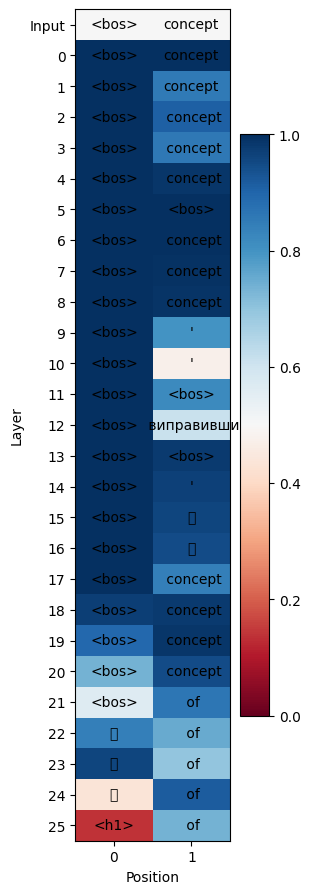

In [24]:
logit_lens_logits = logit_lens_all(cache)
plot_logit_lens(logit_lens_logits, input_tokens)

### Extract model activations

In [25]:
concept_acts: dict[str, dict[str, dict[str, torch.Tensor]]] = {}
for lang in results.keys():
  concept_acts[lang] = {}
  for concept in results[lang]:
    concept_acts[lang][concept] = {}
    _, cache = results[lang][concept]
    for model_hook_id in MODEL_HOOK_IDS:
      resid_stream: torch.Tensor = cache[model_hook_id]

      # Last activation should encode the entire context
      concept_act = resid_stream.squeeze(0)[-1]
      concept_acts[lang][concept][model_hook_id] = concept_act

# rprint(concept_acts)

In [26]:
_, bos_cache = model.run_with_cache("")
bos_act = bos_cache[MODEL_HOOK_ID].squeeze(0)[-1]

In [27]:
# Use steering to verify the quality of extracted activations
from functools import partial

from transformer_lens.hook_points import HookPoint


def steer(resid: torch.Tensor, hook: HookPoint, *, steering_vec: torch.Tensor, steering_coef: float):
  mean_token_act_norm = torch.linalg.vector_norm(resid[:, :, :], dim=-1).mean()
  print("Mean activation magnitude:", mean_token_act_norm.item())
  resid[:, :, :] += steering_vec * mean_token_act_norm * steering_coef

  return resid


try:
  prompt = "My best friend's name is "
  lang, concept = "en", "food"

  print("Expectation:\t" + prompt + concept)
  concept_act = concept_acts[lang][concept][MODEL_HOOK_ID]
  steering_vec = concept_act / torch.linalg.vector_norm(concept_act) - bos_act / torch.linalg.vector_norm(bos_act)
  steering_vec = steering_vec / torch.linalg.vector_norm(steering_vec)
  steering_coef = 3
  logits = model.run_with_hooks(
    prompt,
    fwd_hooks=[
      (MODEL_HOOK_ID, partial(steer, steering_vec=steering_vec, steering_coef=steering_coef)),
    ],
  )
  tokens = logits.argmax(dim=-1)[:, -1]
  print("Reality:\t" + prompt + model.to_string(tokens))
finally:
  model.reset_hooks()

Expectation:	My best friend's name is food
Mean activation magnitude: 394.7506103515625
Reality:	My best friend's name is  food


In [28]:
# TODO: If possible, quantitatively assess the effect of steering on the output distribution (minimal off-target effects, maximal on-target effects)

In [29]:
model_acts = {
  lang: {concept: concept_act[MODEL_HOOK_ID].numpy(force=True) for concept, concept_act in list(concept_acts[lang].items())}
  for lang in concept_acts
}

In [30]:
import numpy as np


def get_top_features(model_act: np.ndarray, k: int = 10):
  top_feature_idx = model_act.argsort(axis=-1)[::-1][:k]  # ReLU activations are non-negative
  top_feature_val = model_act[top_feature_idx]

  return top_feature_val, top_feature_idx

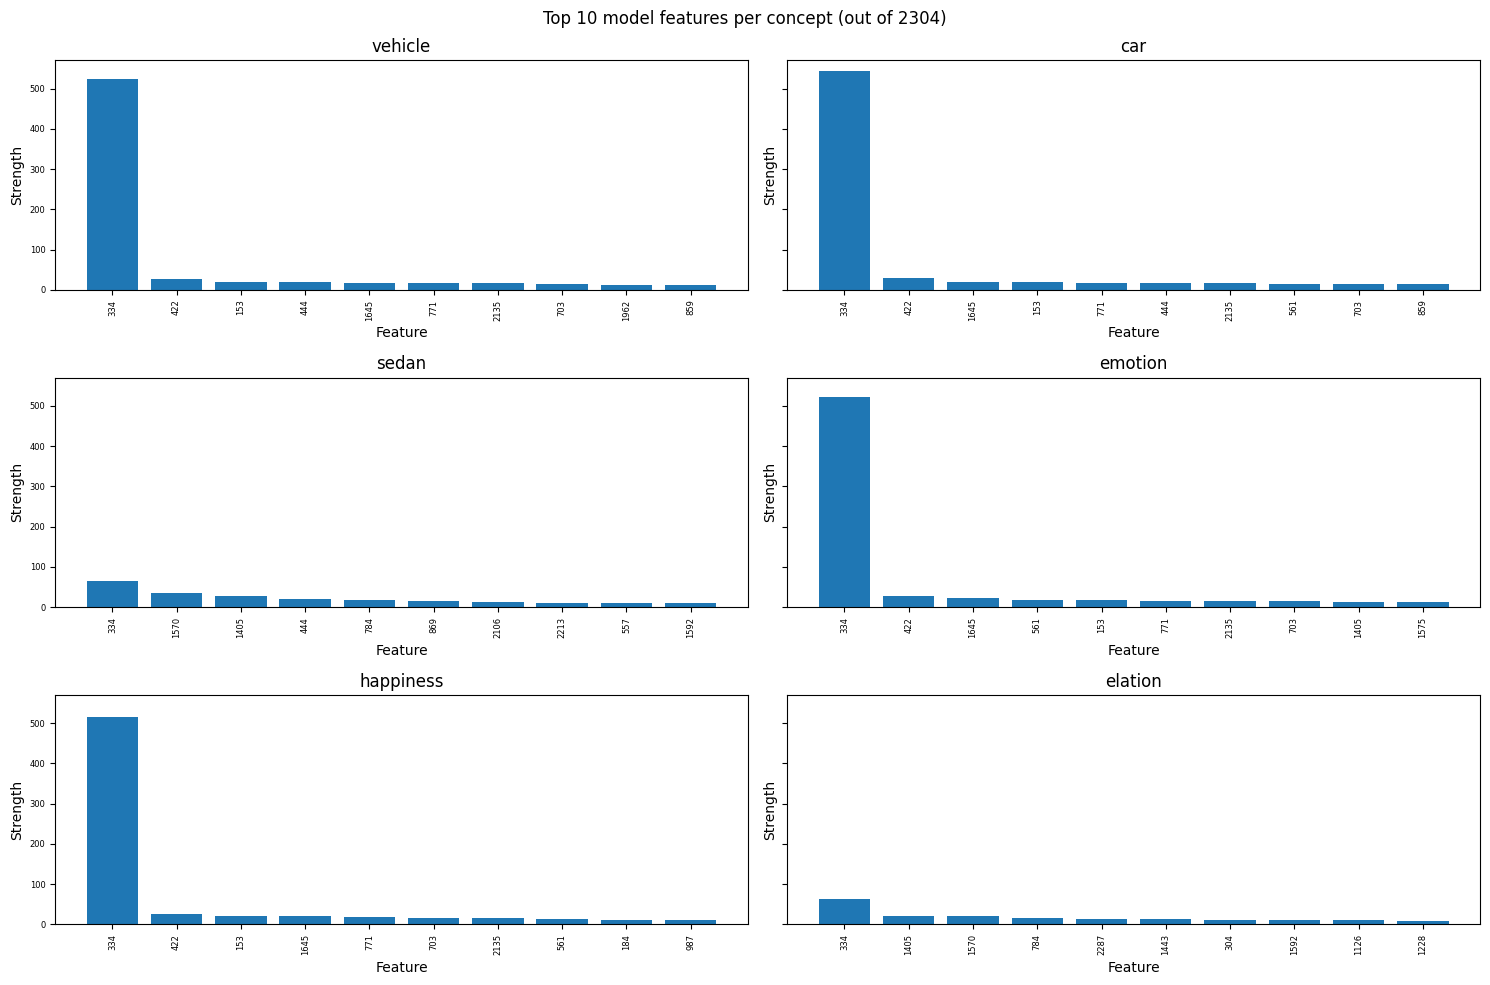

In [31]:
import matplotlib.pyplot as plt


def plot_model_act(model_acts: dict[str, np.ndarray], k: int):
  n = len(model_acts)
  r = int(np.sqrt(n)) + 1
  c = int(np.ceil(n / r))

  fig, axs = plt.subplots(r, c, figsize=(5 * r, 5 * c), sharey=True)
  axs = axs.flatten()

  for i, (concept, model_act) in enumerate(model_acts.items()):
    val, idx = get_top_features(model_act, k=k)

    ax = axs[i]
    ax.bar(range(len(val)), val)
    ax.tick_params(labelsize=6)
    ax.set_xticks(range(len(val)), idx, rotation=90)
    ax.set_ylabel("Strength")
    ax.set_xlabel("Feature")
    ax.set_title(concept)

  fig.suptitle(f"Top {k} model features per concept (out of {model.cfg.d_model})")
  fig.tight_layout()


plot_model_act(dict(list(model_acts["en"].items())[:6]), 10)
plt.savefig(PLOTS_DIR / "top_k_model_acts.png")

In [32]:
concept_model_acts_df = pd.DataFrame(
  {
    (i % 3 + 1, concept, lang): concept_acts[lang][concept][MODEL_HOOK_ID].numpy(force=True)
    for lang in concept_acts
    for (i, concept) in enumerate(concept_acts[lang])
  }
).T
concept_model_acts_df.index.names = ["level", "concept", "lang"]
# concept_model_acts_df = concept_model_acts_df[concept_length_df["length"] == 1]
concept_model_acts_df = concept_model_acts_df.rename(index=concept_map, level="concept")
# concept_model_acts_df = concept_model_acts_df.sort_index()

concept_model_acts_df

0         1         2         3         4     \
level concept   lang                                                     
1     vehicle   en   -2.036656  0.585952 -0.746240  4.089048 -4.578381   
2     car       en   -2.584033  0.588454 -0.225167  3.930790 -4.991175   
3     sedan     en   -0.386309 -0.491489 -5.875853 -2.841981 -0.442956   
1     emotion   en   -1.689994  1.248780  0.994049  4.210644 -4.768674   
2     happiness en   -1.234881  1.895984 -0.875656  3.466781 -4.749636   
...                        ...       ...       ...       ...       ...   
      doll      de   -1.061306  0.862442 -0.368499 -0.974972 -0.104036   
3     puppet    de   -0.912093  1.112530  0.340677  0.291496 -1.906220   
1     beverage  de   -0.733290 -0.281864 -1.386064 -0.991568 -0.131425   
2     liquor    de    1.837358 -2.866964 -2.686815 -0.730785 -2.825313   
3     wine      de   -1.658908  1.138121  0.934249  2.712196 -4.972049   

                          5         6         7         8         9     ...  \
level concept   lang                                                    ...   
1     vehicle   en    0.782552  6.533349 -5.240744 -5.876627 -3.556965  ...   
2     car       en    0.572304  6.473291 -2.711520 -6.483018 -2.695183  ...   
3     sedan     en    1.444355  4.215607  0.944022 -0.753732  0.197932  ...   
1     emotion   en    1.194391  7.814775 -2.951691 -5.691432 -2.706983  ...   
2     happiness en    0.662642  5.385693 -6.952469 -5.803317 -2.503795  ...   
...                        ...       ...       ...       ...       ...  ...   
      doll      de    0.908013  3.457908  1.156694  1.783377  1.870803  ...   
3     puppet    de    1.345147  3.075042  0.828857  0.682791 -1.495222  ...   
1     beverage  de    0.022670  5.496285  1.210911  1.571179 -0.877649  ...   
2     liquor    de    2.135309  1.642688  2.471978  4.258158 -4.572531  ...   
3     wine      de    1.349984  6.379262 -0.821846 -4.269075 -2.699322  ...   

                          2294      2295      2296      2297      2298  \
level concept   lang                                                     
1     vehicle   en    1.155036 -4.719478 -4.130976 -5.209403 -1.329764   
2     car       en    0.943769 -4.483498 -4.710079 -4.130624 -1.486272   
3     sedan     en    1.513382 -3.011935  1.099032 -3.343476  2.545331   
1     emotion   en    0.700717 -5.422851 -5.489636 -4.690050 -1.926134   
2     happiness en    0.366058 -4.851330 -5.139676 -5.612272 -1.636707   
...                        ...       ...       ...       ...       ...   
      doll      de   -0.067783 -2.696052 -2.690453 -3.516272  0.471799   
3     puppet    de    0.439551 -3.583935 -4.370007 -4.270752  1.859132   
1     beverage  de    0.837882 -2.810487 -1.166329 -4.078437  1.738521   
2     liquor    de    3.080884 -3.352084 -2.270103 -8.402528  2.976584   
3     wine      de    0.975697 -5.119182 -5.126820 -3.850148 -1.834007   

                          2299      2300      2301      2302      2303  
level concept   lang                                                    
1     vehicle   en    8.155495 -0.425342  0.882917 -7.489131  3.454222  
2     car       en    8.289689 -4.134354  2.072533 -6.445364  2.021057  
3     sedan     en    0.130041  2.070452 -0.244159 -6.662600  0.166404  
1     emotion   en    8.063503 -0.258609  1.150235 -5.933958  2.288813  
2     happiness en    8.444611 -3.909480  1.339267 -5.754606  2.399473  
...                        ...       ...       ...       ...       ...  
      doll      de    0.331749  2.158024  2.830907 -8.202648  0.623907  
3     puppet    de   -1.595887  1.899871  4.198660 -7.276311  1.414312  
1     beverage  de   -1.548808  2.343655  0.210577 -7.707892  0.721446  
2     liquor    de   -0.630511  7.655376  1.013851 -7.912917  2.069979  
3     wine      de    7.297252  2.631454  1.602636 -3.659940  1.537878  

[315 rows x 2304 columns]

### Visualize model activations

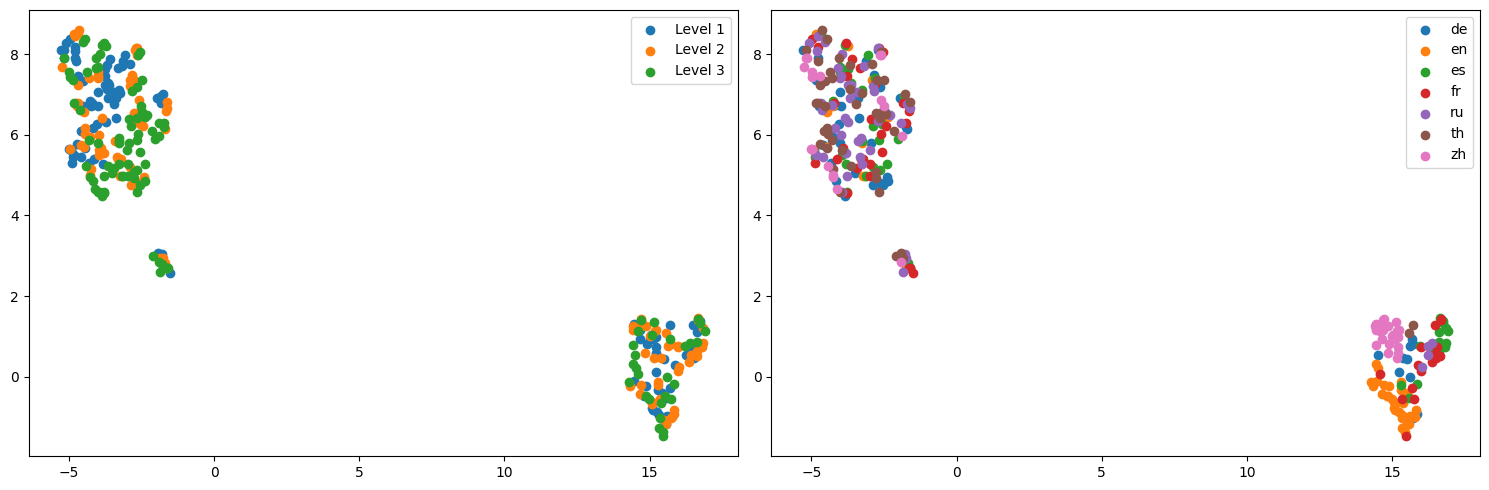

In [33]:
import numpy as np
from umap import UMAP


def visualize_concept_space(
  activations: np.ndarray,
  abstraction_levels: list[int],
  languages: list[str],
  save_path: str = None,
) -> None:
  umap = UMAP(n_components=2, random_state=42)
  activations_2d = umap.fit_transform(activations)

  plt.figure(figsize=(15, 5))
  # plt.suptitle("Activation space (UMAP)")

  plt.subplot(121)
  for level in np.unique(abstraction_levels):
    mask = np.array(abstraction_levels) == level
    plt.scatter(activations_2d[mask, 0], activations_2d[mask, 1], label=f"Level {level}")
  plt.legend()
  # plt.title("By abstraction level")

  plt.subplot(122)
  unique_langs = np.unique(languages)
  for lang in unique_langs:
    mask = np.array(languages) == lang
    plt.scatter(activations_2d[mask, 0], activations_2d[mask, 1], label=lang)
  plt.legend()
  # plt.title("By language")

  plt.tight_layout()
  if save_path:
    plt.savefig(save_path)

concept_model_acts = torch.stack(
  [concept_act[MODEL_HOOK_ID] for lang_acts in concept_acts.values() for concept_act in lang_acts.values()]
)
concept_labels = (en_concepts * len(concept_acts))[: len(concept_model_acts)]
abstraction_levels = [i % 3 + 1 for i in range(len(concept_labels))][: len(concept_model_acts)]
languages = sum(([lang] * len(lang_concepts) for lang, lang_concepts in concept_acts.items()), [])[
  : len(concept_model_acts)
]

visualize_concept_space(
  activations=concept_model_acts.numpy(force=True),
  abstraction_levels=abstraction_levels,
  languages=languages,
  save_path=PLOTS_DIR / "activation_space_umap_before.png",
)

### Perform LDA by sememe

In [34]:
en_sememe_map = {}
for i in range(len(en_concepts)):
  if i % 3 == 0:
    sememe = en_concepts[i].upper()
    en_sememe_map[en_concepts[i]] = sememe
    en_sememe_map[en_concepts[i + 1]] = sememe
    en_sememe_map[en_concepts[i + 2]] = sememe

en_sememe_map

{'vehicle': 'VEHICLE',
 'car': 'VEHICLE',
 'sedan': 'VEHICLE',
 'emotion': 'EMOTION',
 'happiness': 'EMOTION',
 'elation': 'EMOTION',
 'plant': 'PLANT',
 'tree': 'PLANT',
 'oak': 'PLANT',
 'clothes': 'CLOTHES',
 'footwear': 'CLOTHES',
 'boot': 'CLOTHES',
 'furniture': 'FURNITURE',
 'seating': 'FURNITURE',
 'chair': 'FURNITURE',
 'container': 'CONTAINER',
 'bottle': 'CONTAINER',
 'flask': 'CONTAINER',
 'weapon': 'WEAPON',
 'blade': 'WEAPON',
 'sword': 'WEAPON',
 'tool': 'TOOL',
 'knife': 'TOOL',
 'scalpel': 'TOOL',
 'technology': 'TECHNOLOGY',
 'computer': 'TECHNOLOGY',
 'laptop': 'TECHNOLOGY',
 'building': 'BUILDING',
 'house': 'BUILDING',
 'mansion': 'BUILDING',
 'mammal': 'MAMMAL',
 'feline': 'MAMMAL',
 'cat': 'MAMMAL',
 'insect': 'INSECT',
 'beetle': 'INSECT',
 'ladybug': 'INSECT',
 'food': 'FOOD',
 'vegetable': 'FOOD',
 'carrot': 'FOOD',
 'toy': 'TOY',
 'doll': 'TOY',
 'puppet': 'TOY',
 'beverage': 'BEVERAGE',
 'liquor': 'BEVERAGE',
 'wine': 'BEVERAGE'}

In [35]:
sememe_model_acts_df = (
  concept_model_acts_df.rename(index=en_sememe_map)
  .rename_axis(["level", "sememe", "lang"])
  .reorder_levels(["lang", "sememe", "level"])
  .sort_index(level=["lang", "sememe", "level"])
)
sememe_model_acts_df

0         1         2         3         4     \
lang sememe   level                                                     
de   BEVERAGE 1     -0.733290 -0.281864 -1.386064 -0.991568 -0.131425   
              2      1.837358 -2.866964 -2.686815 -0.730785 -2.825313   
              3     -1.658908  1.138121  0.934249  2.712196 -4.972049   
     BUILDING 1      1.957796 -2.342766  1.003589 -2.298697  1.047561   
              2     -0.945639  2.430210  1.479557  3.563846 -4.981039   
...                       ...       ...       ...       ...       ...   
zh   VEHICLE  2     -1.819679  0.176405  0.614204  3.527803 -4.273005   
              3     -1.393458 -0.547217 -2.870152  1.379179  2.036867   
     WEAPON   1     -2.613658  1.522173 -0.425154  4.289204 -4.677447   
              2     -1.644841 -1.101192 -1.639866 -0.301762  0.843509   
              3     -2.007286  0.520818  0.029894  2.537398 -4.654622   

                         5         6         7         8         9     ...  \
lang sememe   level                                                    ...   
de   BEVERAGE 1      0.022670  5.496285  1.210911  1.571179 -0.877649  ...   
              2      2.135309  1.642688  2.471978  4.258158 -4.572531  ...   
              3      1.349984  6.379262 -0.821846 -4.269075 -2.699322  ...   
     BUILDING 1     -0.415194  3.276966  6.044530  0.950398 -2.659725  ...   
              2      2.051919  6.439800 -1.055679 -4.345642 -4.263106  ...   
...                       ...       ...       ...       ...       ...  ...   
zh   VEHICLE  2      0.859847  4.504126  2.525153 -5.942760 -3.779953  ...   
              3      0.948329  2.157704 -0.361114  0.425974 -2.083133  ...   
     WEAPON   1      0.291476  4.916395 -1.409466 -5.931896 -2.552148  ...   
              2      1.548820  1.805755 -1.099713  2.144989 -0.345538  ...   
              3      0.543713  3.723402  1.100308 -5.570458 -1.348651  ...   

                         2294      2295      2296      2297      2298  \
lang sememe   level                                                     
de   BEVERAGE 1      0.837882 -2.810487 -1.166329 -4.078437  1.738521   
              2      3.080884 -3.352084 -2.270103 -8.402528  2.976584   
              3      0.975697 -5.119182 -5.126820 -3.850148 -1.834007   
     BUILDING 1      0.638168 -1.924966 -2.031659 -5.133562  0.353607   
              2      1.303164 -4.461649 -6.779200 -4.294815 -1.359412   
...                       ...       ...       ...       ...       ...   
zh   VEHICLE  2      1.202570 -5.046007 -5.532470 -5.290247 -0.785089   
              3      1.908371  1.368296 -1.316987 -3.697736  2.754886   
     WEAPON   1      1.003698 -5.279180 -5.343534 -3.250427 -1.023598   
              2     -0.226309  0.391132 -3.540227 -0.786596  0.865075   
              3      1.143787 -5.027554 -5.569472 -3.474349 -2.064121   

                         2299      2300      2301      2302      2303  
lang sememe   level                                                    
de   BEVERAGE 1     -1.548808  2.343655  0.210577 -7.707892  0.721446  
              2     -0.630511  7.655376  1.013851 -7.912917  2.069979  
              3      7.297252  2.631454  1.602636 -3.659940  1.537878  
     BUILDING 1     -0.412184  0.753399  0.939558 -5.616443  1.884918  
              2      7.020761 -1.422112  2.068802 -3.209859  1.425379  
...                       ...       ...       ...       ...       ...  
zh   VEHICLE  2      7.201642 -1.621654  2.708660 -6.813827  2.418470  
              3     -1.966404 -2.052227  0.225374 -6.495284  3.290784  
     WEAPON   1      7.224066  4.544678  1.212083 -6.813982  2.975415  
              2      0.132562 -5.026522  0.609242 -4.458018  0.013077  
              3      6.367745  2.300233  2.151107 -5.799764  1.312188  

[315 rows x 2304 columns]

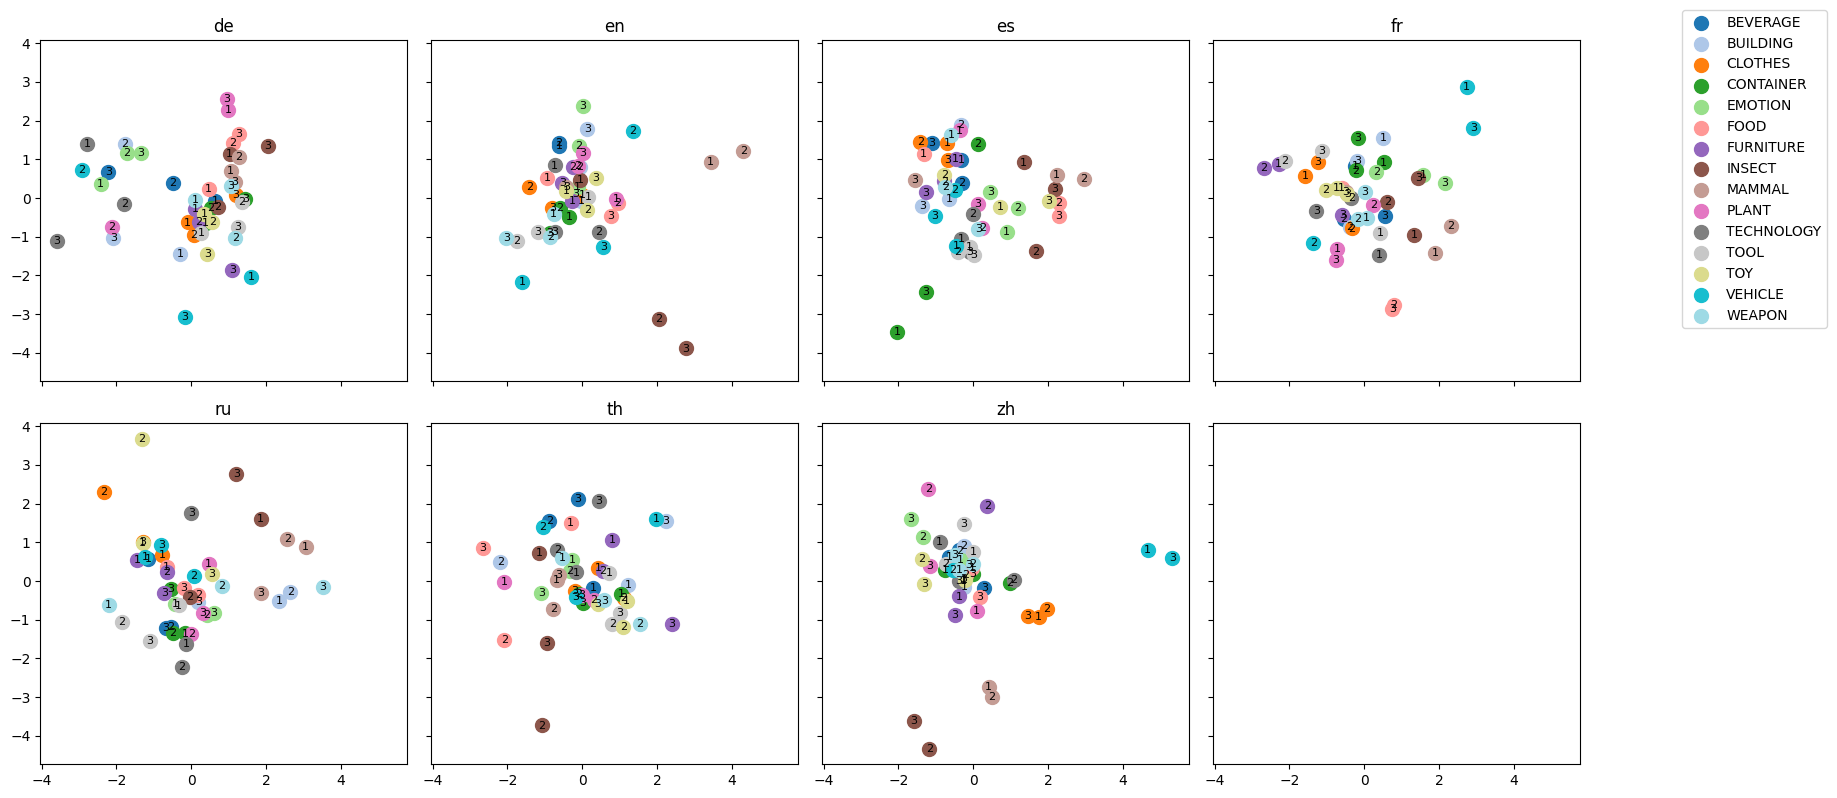

In [36]:
from cycler import cycler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

langs = sememe_model_acts_df.index.get_level_values("lang").unique().to_list()
n_cols = 4
n_rows = int(np.ceil(len(langs) / n_cols))

with plt.style.context({
  "axes.prop_cycle": cycler(color=plt.cm.tab20(np.linspace(0, 1, len(np.unique(sememe_model_acts_df.index.get_level_values("sememe"))))))
}):
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharex=True, sharey=True)
  axs = axs.flatten()

for i, lang in enumerate(langs):
  X = sememe_model_acts_df.loc[lang]
  y = X.index.get_level_values("sememe").to_numpy()

  lda = LinearDiscriminantAnalysis()
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  X_transformed = lda.fit_transform(X_scaled, y)
  X_transformed = pd.DataFrame(X_transformed, index=X.index)

  for sememe in np.unique(y):
    X_sememe = X_transformed.loc[sememe]
    x1 = X_sememe.iloc[:, 0]
    x2 = X_sememe.iloc[:, 1]
    axs[i].scatter(x1, x2, label=sememe, s=100)
    for level in X_sememe.index:
      axs[i].text(x1[level], x2[level], level, ha="center", va="center", fontsize=8)

  axs[i].set_title(f"{lang}")

fig.legend(handles=axs[0].get_legend_handles_labels()[0], labels=axs[0].get_legend_handles_labels()[1], bbox_to_anchor=(1.05, 1), loc="upper left")
# fig.suptitle("Activation space by language (first two LDA components)")
fig.tight_layout()
plt.show()

In [37]:
def plot_lda(X: pd.DataFrame, y: np.ndarray, y_transformed: np.ndarray, suffix: str = "", plot_explained_variance: bool = True):
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

  lda = LinearDiscriminantAnalysis()
  X_transformed = lda.fit_transform(X_scaled, y_transformed)
  X_transformed = pd.DataFrame(X_transformed, index=X.index)

  if plot_explained_variance:
    print("Explained variance ratio:", lda.explained_variance_ratio_)
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(lda.explained_variance_ratio_)), lda.explained_variance_ratio_)
    plt.xlabel("LDA component")
    plt.ylabel("Explained variance ratio")
    plt.xticks(range(len(lda.explained_variance_ratio_)), range(1, len(lda.explained_variance_ratio_) + 1))
    plt.savefig(PLOTS_DIR / "lda_explained_variance_ratio.png")
    plt.show()

  with plt.style.context({
    "axes.prop_cycle": cycler(color=plt.cm.rainbow(np.linspace(0, 1, len(np.unique(y)))))
  }):
    plt.figure(figsize=(10, 10))
    # plt.suptitle("Activation space (first two LDA components)")

    for sememe in np.unique(y):
      X_sememe = X_transformed.loc[:, sememe, :]
      x1_idx, x2_idx = 0, 1
      x1 = X_sememe.iloc[:, x1_idx]
      x2 = X_sememe.iloc[:, x2_idx]
      plt.scatter(x1, x2, label=sememe, s=100)
      for lang, level in X_sememe.index:
        plt.text(x1[lang, level], x2[lang, level], lang, ha="center", va="center", fontsize=8)

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f"activation_space_lda_c{x1_idx}_c{x2_idx}{suffix}.png")
    plt.show()

  return X_scaled, X_transformed, y_transformed

Explained variance ratio: [0.14261696 0.12475828 0.10383911 0.09201987 0.08444875 0.07892126
 0.06845943 0.05794165 0.05250756 0.04852736 0.04454321 0.04315886
 0.03351741 0.02474028]


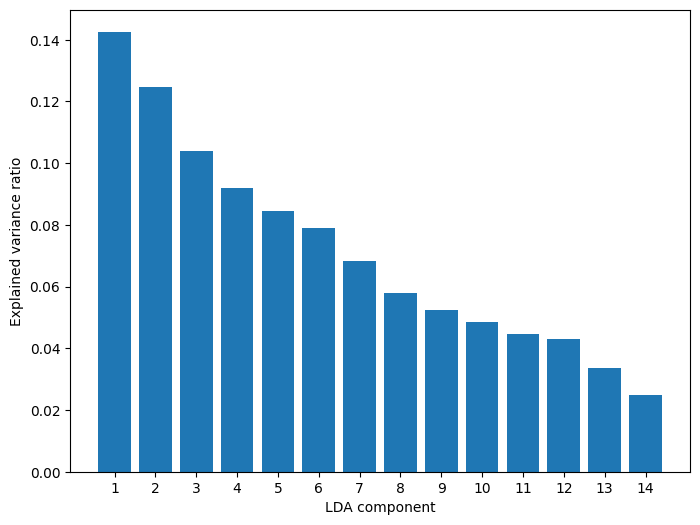

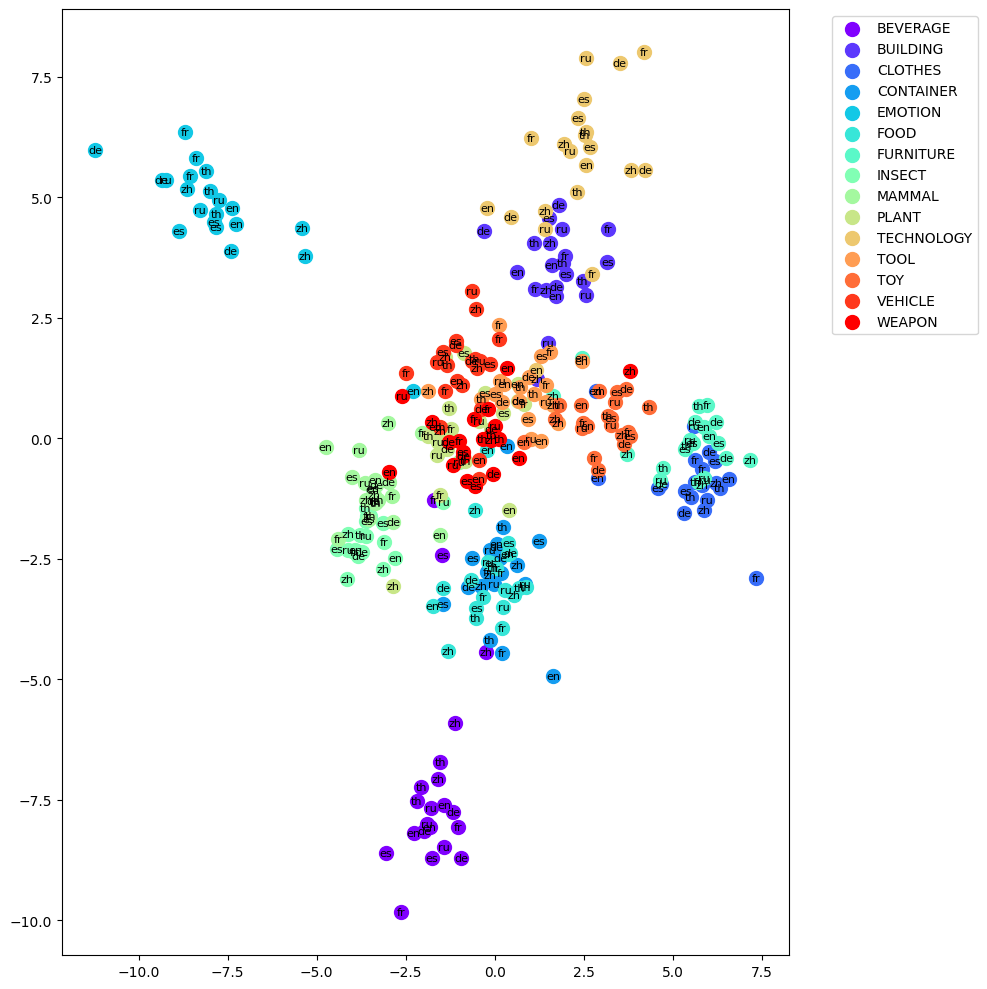

In [38]:
X = sememe_model_acts_df
y = X.index.get_level_values("sememe").to_numpy()
X_scaled, X_transformed, y_transformed = plot_lda(X, y, y)

In [39]:
from sklearn.metrics import calinski_harabasz_score

# CH score = normalized LDA maximization objective (trace of between-class scatter / trace of within-class scatter)
# LDA and CH agree in worldview: everything is Gaussian blobs, and centroids + spread matter most.
# CH increases when class centroids move apart or when classes get tighter.
score_before = calinski_harabasz_score(X_scaled, y)
score_after = calinski_harabasz_score(X_transformed, y_transformed)

# Should be higher post-LDA
print(f"Separation score: {score_before:.2f} → {score_after:.2f}")

Separation score: 3.74 → 123.42


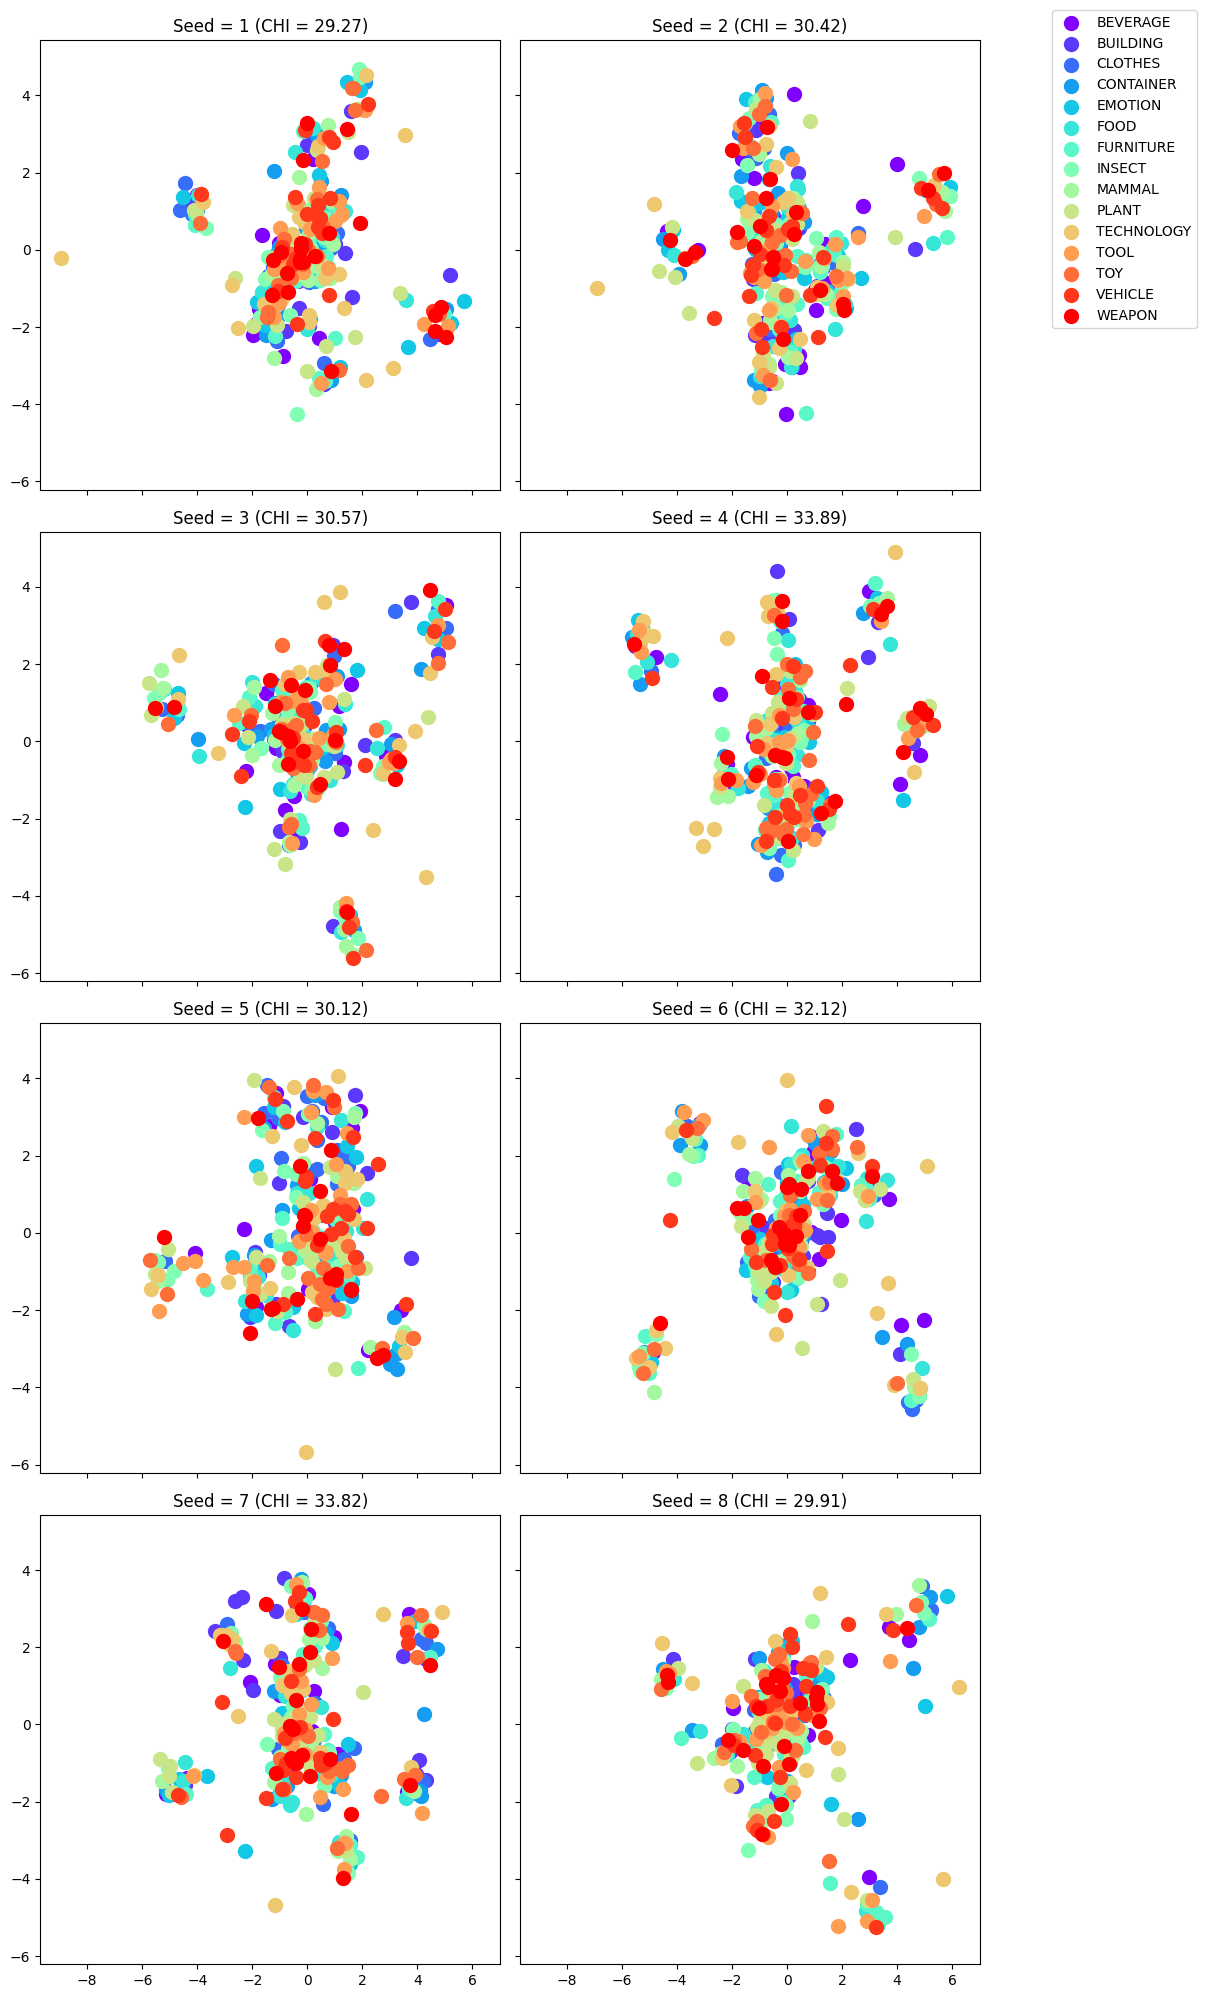

In [40]:
from sklearn.metrics import calinski_harabasz_score


def plot_shuffled_lda(X: pd.DataFrame, y: np.ndarray, suffix: str = ""):
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

  with plt.style.context({
    "axes.prop_cycle": cycler(color=plt.cm.rainbow(np.linspace(0, 1, len(np.unique(y)))))
  }):
    SHUFFLE_TRIALS = 8
    n_cols = 2
    n_rows = int(np.ceil(SHUFFLE_TRIALS / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True, sharey=True)
    axs = axs.flatten()

    for i in range(SHUFFLE_TRIALS):
      y_transformed = np.random.default_rng(i + 1).permutation(y)

      lda = LinearDiscriminantAnalysis()
      X_transformed = lda.fit_transform(X_scaled, y_transformed)
      X_transformed = pd.DataFrame(X_transformed, index=X.index)

      ch_score = calinski_harabasz_score(X_transformed, y_transformed)

      for sememe in np.unique(y):
        X_sememe = X_transformed.loc[:, sememe, :]
        x1_idx, x2_idx = 0, 1
        x1 = X_sememe.iloc[:, x1_idx]
        x2 = X_sememe.iloc[:, x2_idx]
        axs[i].scatter(x1, x2, label=sememe, s=100)
        axs[i].set_title(f"Seed = {i + 1} (CHI = {ch_score:.2f})")
        # for lang, level in X_sememe.index:
        #   axs[i].text(x1[lang, level], x2[lang, level], lang, ha="center", va="center", fontsize=8)

    fig.legend(handles=axs[0].get_legend_handles_labels()[0], labels=axs[0].get_legend_handles_labels()[1], bbox_to_anchor=(1.05, 1), loc="upper left")
    fig.tight_layout()
    plt.savefig(PLOTS_DIR / f"activation_space_lda_c{x1_idx}_c{x2_idx}_shuffled{suffix}.png")
    plt.show()


plot_shuffled_lda(sememe_model_acts_df, sememe_model_acts_df.index.get_level_values("sememe").to_numpy())

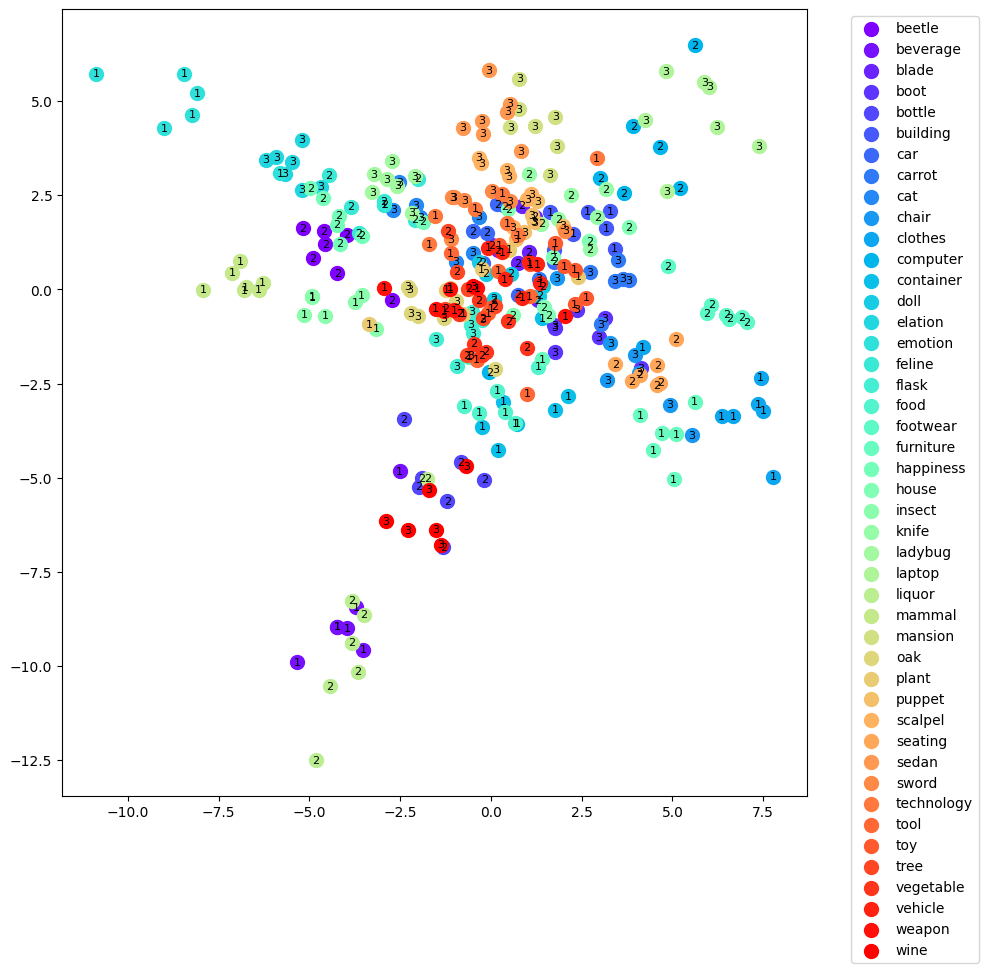

In [41]:
X_concept = concept_model_acts_df
y_concept = X_concept.index.get_level_values("concept").to_numpy()
X_scaled_concept, X_transformed_concept, y_transformed_concept = plot_lda(X_concept, y_concept, y_concept, suffix="_concept", plot_explained_variance=False)

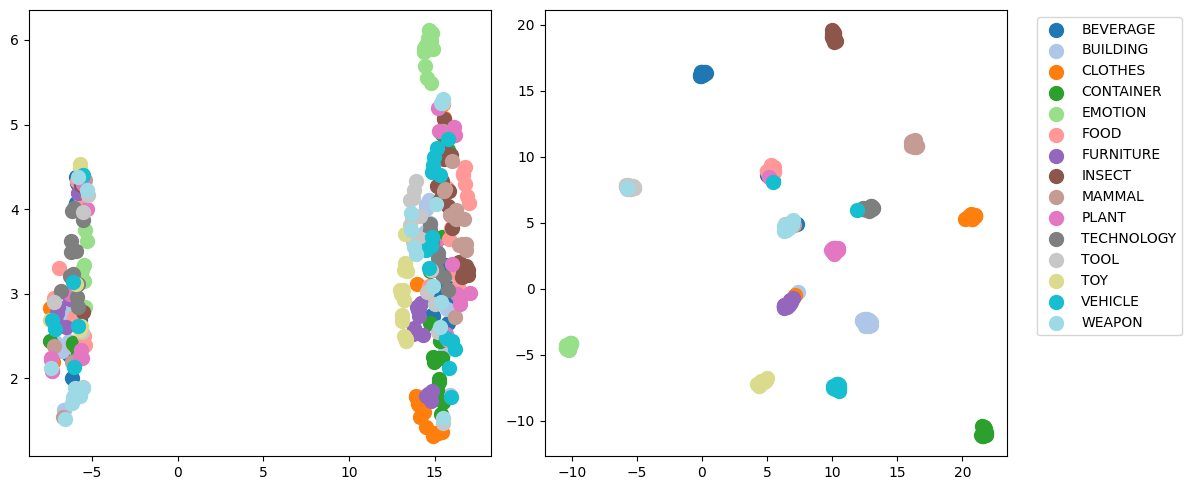

In [42]:
umap = UMAP(n_components=2, random_state=42)  # Default parameters
X_umap = umap.fit_transform(X_scaled)
X_umap = pd.DataFrame(X_umap, index=X.index)

transformed_umap = UMAP(n_components=2, random_state=42)
X_transformed_umap = transformed_umap.fit_transform(X_transformed)
X_transformed_umap = pd.DataFrame(X_transformed_umap, index=X_transformed.index)

with plt.style.context({
  "axes.prop_cycle": cycler(color=plt.cm.tab20(np.linspace(0, 1, len(np.unique(y)))))
}):
  plt.figure(figsize=(12, 5))
  # plt.suptitle("Activation space (UMAP)")

  plt.subplot(1, 2, 1)
  # plt.title("Before LDA")
  for sememe in np.unique(y):
    X_sememe = X_umap.loc[:, sememe, :]
    x1 = X_sememe.iloc[:, 0]
    x2 = X_sememe.iloc[:, 1]
    plt.scatter(x1, x2, label=sememe, s=100)
    # for lang, level in X_sememe.index:
    #   plt.text(x1[lang, level], x2[lang, level], lang, ha="center", va="center", fontsize=8)

  plt.subplot(1, 2, 2)
  # plt.title("After LDA")
  for sememe in np.unique(y):
    X_sememe = X_transformed_umap.loc[:, sememe, :]
    x1 = X_sememe.iloc[:, 0]
    x2 = X_sememe.iloc[:, 1]
    plt.scatter(x1, x2, label=sememe, s=100)
    # for lang, level in X_sememe.index:
    #   plt.text(x1[lang, level], x2[lang, level], lang, ha="center", va="center", fontsize=8)

  plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
  plt.tight_layout()
  plt.savefig(PLOTS_DIR / "activation_space_umap_before_after.png")
  plt.show()

### For each concept at each abstraction level, compute cross-lingual similarity

In [43]:
from collections import defaultdict
from itertools import combinations
from typing import Mapping, Sequence, TypeVar

import numpy as np


def iou_similarity(l1: Sequence, l2: Sequence) -> float:
  """Compute the intersection over union, a.k.a. Jaccard similarity."""
  set1 = set(l1)
  set2 = set(l2)

  intersection = set1 & set2
  union = set1 | set2

  return len(intersection) / len(union)


def raiou_similarity(l1: Sequence, l2: Sequence) -> float:
  """Compute a rank-aware generalization of intersection over union (RaIoU)."""
  length = len(l1)

  ious = []
  for i in range(1, length + 1):
    iou = iou_similarity(l1[:i], l2[:i])
    ious.append(iou)

  return sum(ious) / length


def cosine_similarity(l1: Sequence, l2: Sequence) -> float:
  return l1 @ l2 / (np.linalg.norm(l1) * np.linalg.norm(l2))


K = TypeVar("K")
V = TypeVar("V")


def compute_agg_metrics(metrics: Mapping[K, Sequence[V]]) -> dict[K, V]:
  results = {}
  for k, v in metrics.items():
    results[f"mean_{k}"] = sum(v) / len(v)

  return results

def compute_crosslingual_similarity_metrics(model_acts_df: pd.DataFrame) -> pd.DataFrame:
  crosslingual_similarity_metrics = defaultdict(dict)
  for level in model_acts_df.index.get_level_values("level").unique():
    level_concepts = model_acts_df.loc[level].index.get_level_values("concept").unique()
    for concept in level_concepts:
      concept_acts = model_acts_df.loc[(level, concept)]
      concept_langs = concept_acts.index.get_level_values("lang").unique()

      concept_metrics: dict[str, list[float]] = defaultdict(list)
      for lang1, lang2 in combinations(concept_langs, 2):
        concept_act_lang1 = concept_acts.loc[lang1].to_numpy()
        concept_act_lang2 = concept_acts.loc[lang2].to_numpy()

        concept_metrics["act_cosine"].append(cosine_similarity(concept_act_lang1, concept_act_lang2))

      crosslingual_similarity_metrics[(level, concept)] = compute_agg_metrics(concept_metrics)

  crosslingual_similarity_metrics_df = pd.DataFrame(crosslingual_similarity_metrics).T
  crosslingual_similarity_metrics_df.index.names = ["level", "concept"]
  crosslingual_similarity_metrics_df = crosslingual_similarity_metrics_df.sort_index()

  return crosslingual_similarity_metrics_df

In [44]:
concept_metrics_df = compute_crosslingual_similarity_metrics(concept_model_acts_df)
concept_metrics_df.to_csv(TABLES_DIR / "crosslingual_concept_metrics.csv")
concept_metrics_df.head()

mean_act_cosine
level concept                   
1     beverage          0.712102
      building          0.670523
      clothes           0.705568
      container         0.631161
      emotion           0.627320

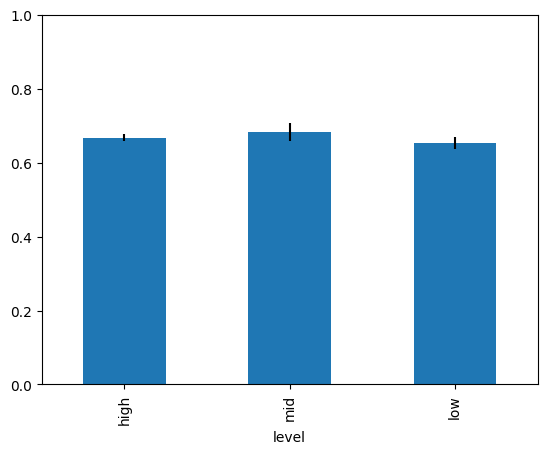

In [45]:
# Average cross-lingual similarity across abstraction levels
grouped_concept_metrics_df = concept_metrics_df.rename(index={1: "high", 2: "mid", 3: "low"}, level="level").groupby(
  level="level",
  sort=False,
)
grouped_concept_metrics_df.mean().plot.bar(
  # title="Average cross-lingual similarity (before LDA)",
  yerr=grouped_concept_metrics_df.sem(),
  ylim=(0, 1),
  legend=False,
)
plt.savefig(PLOTS_DIR / "avg_crosslingual_similarity_before.png")

In [46]:
sememe_metrics_df = compute_crosslingual_similarity_metrics(X_transformed.reorder_levels(["level", "sememe", "lang"]).rename_axis(["level", "concept", "lang"]))
sememe_metrics_df.to_csv(TABLES_DIR / "crosslingual_sememe_metrics.csv")
sememe_metrics_df.head()

mean_act_cosine
level concept                   
1     BEVERAGE          0.854606
      BUILDING          0.715414
      CLOTHES           0.749298
      CONTAINER         0.851225
      EMOTION           0.802734

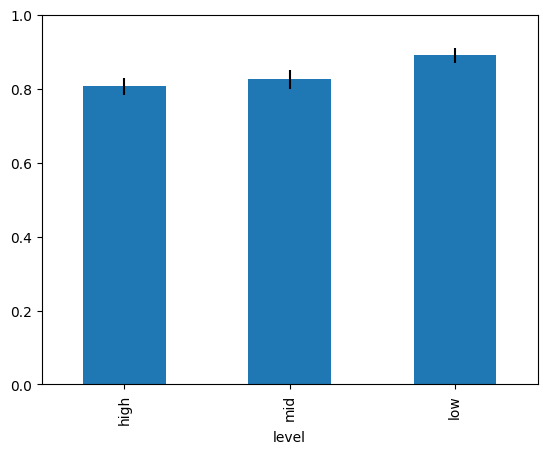

In [47]:
# Average cross-lingual similarity across abstraction levels
grouped_sememe_metrics_df = sememe_metrics_df.rename(index={1: "high", 2: "mid", 3: "low"}, level="level").groupby(
  level="level",
  sort=False,
)
grouped_sememe_metrics_df.mean().plot.bar(
  # title="Average cross-lingual similarity (after LDA)",
  yerr=grouped_sememe_metrics_df.sem(),
  ylim=(0, 1),
  legend=False,
)
plt.savefig(PLOTS_DIR / "avg_crosslingual_similarity_after.png")

### Perform a permutation test to compare cross-lingual similarity across abstraction levels

In [48]:
# Permutation test for cross-lingual similarity
from typing import Callable, Literal

from scipy.stats import norm


def permutation_test(
  data: pd.Series,
  alternative: Literal["two_sided", "greater", "less"] = "two_sided",
  min_permutations: int = 1_000,
  max_permutations: int = 100_000,
  convergence_check_interval: int = 100,
  convergence_check_ci_alpha: float = 0.01,
  convergence_check_ci_width: float = 0.01,
  generator: np.random.Generator | None = None,
):
  """Perform Monte-Carlo permutation test to compare cross-lingual similarity across abstraction levels.

  Args:
    data: The data to analyze.
    alternative: The alternative hypothesis.
    min_permutations: The minimum number of permutations to perform.
    max_permutations: The maximum number of permutations to perform.
    convergence_check_interval: The number of iterations between early stopping checks.
    convergence_check_ci_alpha: The desired confidence level for the p-value estimate in early stopping checks.
    convergence_check_ci_width: The target width of the confidence interval for the p-value estimate in early stopping checks.
    generator: The random number generator to use for reproducibility. If not provided, the default one will be used.
  """
  compare: Callable[[np.ndarray, float], np.ndarray]
  if alternative == "two_sided":
    compare = lambda x, y: np.abs(x) >= np.abs(y)
  elif alternative == "greater":
    compare = lambda x, y: x >= y
  elif alternative == "less":
    compare = lambda x, y: x <= y
  else:
    raise ValueError(f"Invalid alternative: {alternative}")

  if min_permutations > max_permutations:
    raise ValueError(f"min_permutations ({min_permutations}) must be less than max_permutations ({max_permutations})")

  convergence_check_z_score = norm.ppf(1 - convergence_check_ci_alpha / 2)

  if generator is None:
    generator = np.random.default_rng()

  levels = data.index.get_level_values("level").unique()

  # Get the observed differences between levels
  observed_means = data.groupby(level="level", sort=False).mean()

  # Initialize arrays to store observed and permuted (null) differences
  observed_diffs: dict[tuple, float] = {}
  permuted_diffs: dict[tuple, list[float]] = {}
  for level1, level2 in combinations(levels, 2):
    observed_diffs[(level1, level2)] = observed_means[level1] - observed_means[level2]
    permuted_diffs[(level1, level2)] = []

  def compute_p_value(ll: tuple) -> float:
    """Calculate the p-value as the proportion of sampled permutations where the difference in means is at least as extreme as the observed difference."""
    permuted_diff = np.array(permuted_diffs[ll])
    observed_diff = observed_diffs[ll]

    p_value = compare(permuted_diff, observed_diff).mean()

    return p_value

  # Perform permutations
  permuted_data = data.copy()
  for i in range(max_permutations):
    check_convergence = i >= min_permutations and (i + 1) % convergence_check_interval == 0
    if check_convergence:
      converged = True

    # Randomly permute the level labels
    permuted_levels = generator.permutation(data.index.get_level_values("level"))
    permuted_data.index = pd.MultiIndex.from_arrays(
      [permuted_levels, data.index.get_level_values("concept")], names=["level", "concept"]
    )

    # Calculate permuted differences
    permuted_means = permuted_data.groupby(level="level", sort=False).mean()
    for level1, level2 in combinations(levels, 2):
      permuted_diffs[(level1, level2)].append(permuted_means[level1] - permuted_means[level2])

      # Stop early if the p-value is known with high confidence
      if check_convergence:
        p_value = compute_p_value((level1, level2))

        # Standard error of the p-value (assuming normal distribution)
        p_value_se = np.sqrt(p_value * (1 - p_value) / (i + 1))
        p_value_ci_width = 2 * convergence_check_z_score * p_value_se
        if p_value_ci_width > convergence_check_ci_width:
          converged = False

    if check_convergence and converged:
      break

  p_values: dict[tuple, float] = {}
  for level1, level2 in combinations(levels, 2):
    p_values[(level1, level2)] = compute_p_value((level1, level2))

  return {
    ll: {
      "observed_diff": observed_diffs[ll],
      "p_value": p_values[ll],  # Observed significance
      "n_permutations": i + 1,
    }
    for ll in combinations(levels, 2)
  }

In [49]:
# Perform a permutation test, applying Holm-Bonferroni correction to p-values
from statsmodels.stats.multitest import multipletests


def perform_permutation_test(metrics_df: pd.DataFrame, alpha: float = 0.05) -> tuple[pd.Series, pd.DataFrame]:
  permutation_generator = np.random.default_rng(42)
  permutation_results = defaultdict(dict)
  for ll, ll_results in permutation_test(
    metrics_df["mean_act_cosine"],
    alternative="two_sided",
    max_permutations=50_000,
    generator=permutation_generator,
  ).items():
    for field, value in ll_results.items():
      permutation_results[(*ll, field)] = value

  permutation_results_df = pd.Series(permutation_results)
  permutation_p_values_df = permutation_results_df.loc[(slice(None), slice(None), "p_value")]

  p_values = permutation_p_values_df.to_numpy().ravel()
  reject, p_corrected, _, _ = multipletests(
    p_values,
    alpha=alpha,
    method="holm",
  )

  corrected_permutation_p_values_df = pd.DataFrame(
    {
      "p-value": p_values,
      "Corrected p-value": p_corrected,
      f"Reject H0 at α={alpha}?": reject,
    }
  )
  corrected_permutation_p_values_df.index = permutation_p_values_df.index

  return permutation_results_df, corrected_permutation_p_values_df

In [50]:
concept_permutation_results_df, concept_corrected_permutation_p_values_df = perform_permutation_test(concept_metrics_df)
concept_permutation_results_df.to_csv(TABLES_DIR / "similarity_permutation_test_results_before.csv")
concept_corrected_permutation_p_values_df.to_csv(TABLES_DIR / "similarity_permutation_test_corrected_results_before.csv")
concept_permutation_results_df

1  2  observed_diff        -0.015200
      p_value               0.584920
      n_permutations    50000.000000
   3  observed_diff         0.014345
      p_value               0.609720
      n_permutations    50000.000000
2  3  observed_diff         0.029545
      p_value               0.274840
      n_permutations    50000.000000
dtype: float64

In [51]:
concept_corrected_permutation_p_values_df

p-value  Corrected p-value  Reject H0 at α=0.05?
1 2  0.58492            1.00000                 False
  3  0.60972            1.00000                 False
2 3  0.27484            0.82452                 False

In [52]:
sememe_permutation_results_df, sememe_corrected_permutation_p_values_df = perform_permutation_test(sememe_metrics_df)
sememe_permutation_results_df.to_csv(TABLES_DIR / "similarity_permutation_test_results_after.csv")
sememe_corrected_permutation_p_values_df.to_csv(TABLES_DIR / "similarity_permutation_test_corrected_results_after.csv")
sememe_permutation_results_df

1  2  observed_diff        -0.018833
      p_value               0.590180
      n_permutations    50000.000000
   3  observed_diff        -0.084134
      p_value               0.011860
      n_permutations    50000.000000
2  3  observed_diff        -0.065300
      p_value               0.057600
      n_permutations    50000.000000
dtype: float64

In [53]:
sememe_corrected_permutation_p_values_df

p-value  Corrected p-value  Reject H0 at α=0.05?
1 2  0.59018            0.59018                 False
  3  0.01186            0.03558                  True
2 3  0.05760            0.11520                 False

### Compute within-language cross-concept similarity as a baseline

In [54]:
crosslingual_concept_baseline_metrics = defaultdict(dict)
for level in concept_model_acts_df.index.get_level_values("level").unique():
  level_concepts = concept_model_acts_df.loc[level].index.get_level_values("concept").unique()
  level_langs = concept_model_acts_df.loc[level].index.get_level_values("lang").unique()
  for lang in level_langs:
    lang_idx = concept_model_acts_df.loc[level, :, lang]
    lang_concepts = lang_idx.index.get_level_values("concept").unique()

    lang_metrics: dict[str, list[float]] = defaultdict(list)
    for concept1, concept2 in combinations(lang_concepts, 2):
      lang_metrics["act_cosine"].append(
        cosine_similarity(
          concept_model_acts_df.loc[(level, concept1, lang)], concept_model_acts_df.loc[(level, concept2, lang)]
        )
      )

    crosslingual_concept_baseline_metrics[(level, lang)] = compute_agg_metrics(lang_metrics)

concept_baseline_metrics_df = pd.DataFrame(crosslingual_concept_baseline_metrics).T
concept_baseline_metrics_df.index.names = ["level", "lang"]
concept_baseline_metrics_df = concept_baseline_metrics_df.sort_index()
concept_baseline_metrics_df

mean_act_cosine
level lang                 
1     de           0.645383
      en           0.854943
      es           0.643850
      fr           0.617631
      ru           0.676698
      th           0.663059
      zh           0.822532
2     de           0.515327
      en           0.700388
      es           0.636386
      fr           0.650702
      ru           0.655608
      th           0.662974
      zh           0.734251
3     de           0.540694
      en           0.689857
      es           0.584202
      fr           0.585061
      ru           0.611588
      th           0.609590
      zh           0.624757

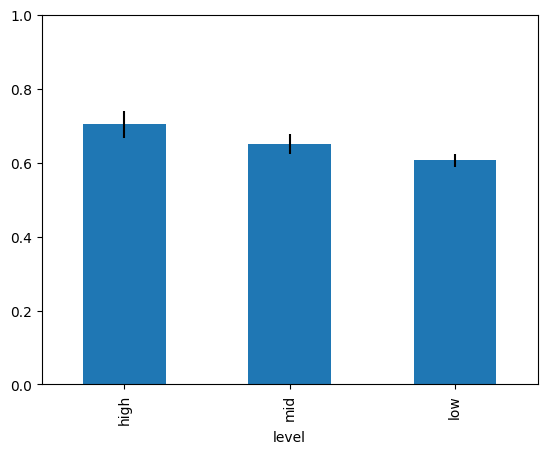

In [55]:
grouped_concept_baseline_metrics_df = concept_baseline_metrics_df.rename(
  index={1: "high", 2: "mid", 3: "low"}, level="level"
).groupby(
  level="level",
  sort=False,
)
grouped_concept_baseline_metrics_df.mean().plot.bar(
  # title="Average cross-concept similarity (before LDA)",
  yerr=grouped_concept_baseline_metrics_df.sem(),
  ylim=(0, 1),
  legend=False,
)
plt.savefig(PLOTS_DIR / "avg_crossconcept_similarity_before.png")

### Compute average within-sememe cross-lingual similarity

In [56]:
sememe_metrics = {}
for lang in sememe_model_acts_df.index.get_level_values("lang").unique():
  sememe_metrics[lang] = {}
  for sememe in sememe_model_acts_df.loc[lang].index.get_level_values("sememe").unique():
    sememe_metrics[lang][sememe] = defaultdict(dict)
    sememe_levels = sememe_model_acts_df.loc[lang, sememe].index.get_level_values("level").unique()
    for level1, level2 in combinations(sememe_levels, 2):
      sememe_idx_level1 = sememe_model_acts_df.loc[lang, sememe, level1].to_numpy()
      sememe_idx_level2 = sememe_model_acts_df.loc[lang, sememe, level2].to_numpy()
      sememe_metrics[lang][sememe][(level1, level2)]["act_cosine"] = cosine_similarity(sememe_idx_level1, sememe_idx_level2)

sememe_metrics_flat = {}
for lang in sememe_metrics:
  for sememe in sememe_metrics[lang]:
    for level1, level2 in sememe_metrics[lang][sememe]:
      sememe_metrics_flat[(lang, sememe, level1, level2)] = sememe_metrics[lang][sememe][(level1, level2)]

flat_sememe_metrics_df = pd.DataFrame(sememe_metrics_flat).T
flat_sememe_metrics_df.index.names = ["lang", "sememe", "level1", "level2"]
flat_sememe_metrics_df

act_cosine
lang sememe   level1 level2            
de   BEVERAGE 1      2         0.676332
                     3         0.452253
              2      3         0.472265
     BUILDING 1      2         0.464289
                     3         0.442721
...                                 ...
zh   VEHICLE  1      3         0.772944
              2      3         0.554215
     WEAPON   1      2         0.494872
                     3         0.990881
              2      3         0.485767

[315 rows x 1 columns]

In [57]:
agg_sememe_metrics_df = (
  flat_sememe_metrics_df.groupby(level=["lang", "sememe"]).mean().rename(columns={"act_cosine": "mean_act_cosine"})
)
agg_sememe_metrics_df

mean_act_cosine
lang sememe                     
de   BEVERAGE           0.533617
     BUILDING           0.631754
     CLOTHES            0.574430
     CONTAINER          0.729420
     EMOTION            0.635291
...                          ...
zh   TECHNOLOGY         0.990303
     TOOL               0.661173
     TOY                0.635767
     VEHICLE            0.614287
     WEAPON             0.657173

[105 rows x 1 columns]

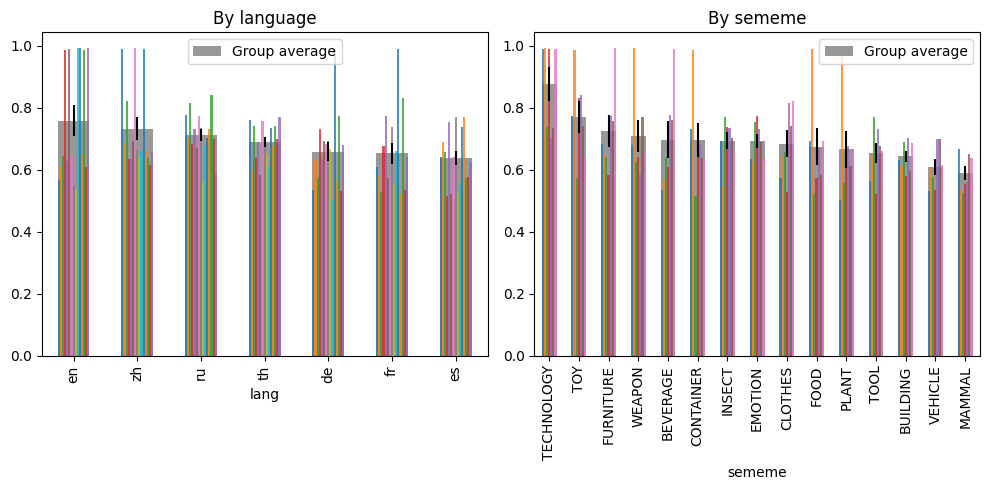

In [58]:
plt.figure(figsize=(10, 5))
# plt.suptitle("Within-sememe cosine similarity (before LDA)")

plt.subplot(121)
agg_sememe_metrics_by_lang_df = agg_sememe_metrics_df.reset_index().pivot(
  index="lang", columns="sememe", values="mean_act_cosine"
)
agg_sememe_metrics_by_lang_mean_df = (
  agg_sememe_metrics_by_lang_df.mean(axis=1).sort_values(ascending=False).rename("Group average")
)
agg_sememe_metrics_by_lang_mean_df.plot.bar(
  ax=plt.gca(),
  alpha=0.8,
  color="tab:gray",
  legend=True,
  yerr=agg_sememe_metrics_by_lang_df.sem(axis=1),
)
agg_sememe_metrics_by_lang_df.loc[agg_sememe_metrics_by_lang_mean_df.index].plot.bar(
  ax=plt.gca(),
  alpha=0.8,
  title="By language",
  legend=False,
)

plt.subplot(122)
agg_sememe_metrics_by_sememe_df = agg_sememe_metrics_df.reset_index().pivot(
  index="sememe", columns="lang", values="mean_act_cosine"
)
agg_sememe_metrics_by_sememe_mean_df = (
  agg_sememe_metrics_by_sememe_df.mean(axis=1).sort_values(ascending=False).rename("Group average")
)
agg_sememe_metrics_by_sememe_mean_df.plot.bar(
  ax=plt.gca(),
  alpha=0.8,
  color="tab:gray",
  legend=True,
  yerr=agg_sememe_metrics_by_sememe_df.sem(axis=1),
)
agg_sememe_metrics_by_sememe_df.loc[agg_sememe_metrics_by_sememe_mean_df.index].plot.bar(
  ax=plt.gca(),
  alpha=0.8,
  title="By sememe",
  legend=False,
)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "within_sememe_similarity_before.png")